# Clustering of Travel Reviews


## Introduction / Overview
The dataset we will be working with in this task has no targets given. So we will investigate what the ideal number of clusters is for the dataset, the natural clusters.

We will also attempt finding which algorithm is the best at finding the natural clusters. The comparisons will be done with two different algorithms. The elbow method and the silhoutte method.


## The dataset

- #### What is the purpose of this dataset?
The purpose

- #### What are the features? 

The features 

- #### What are the targets? 

The targets


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.colors import Colormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [103]:
trip_advisor_review_csv = pd.read_csv('tripadvisor_review.csv',sep=',')
dataset = trip_advisor_review_csv.drop('User ID', axis=1)
dataset.head()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


array([[<Axes: title={'center': 'Category 1'}>,
        <Axes: title={'center': 'Category 2'}>,
        <Axes: title={'center': 'Category 3'}>],
       [<Axes: title={'center': 'Category 4'}>,
        <Axes: title={'center': 'Category 5'}>,
        <Axes: title={'center': 'Category 6'}>],
       [<Axes: title={'center': 'Category 7'}>,
        <Axes: title={'center': 'Category 8'}>,
        <Axes: title={'center': 'Category 9'}>],
       [<Axes: title={'center': 'Category 10'}>, <Axes: >, <Axes: >]],
      dtype=object)

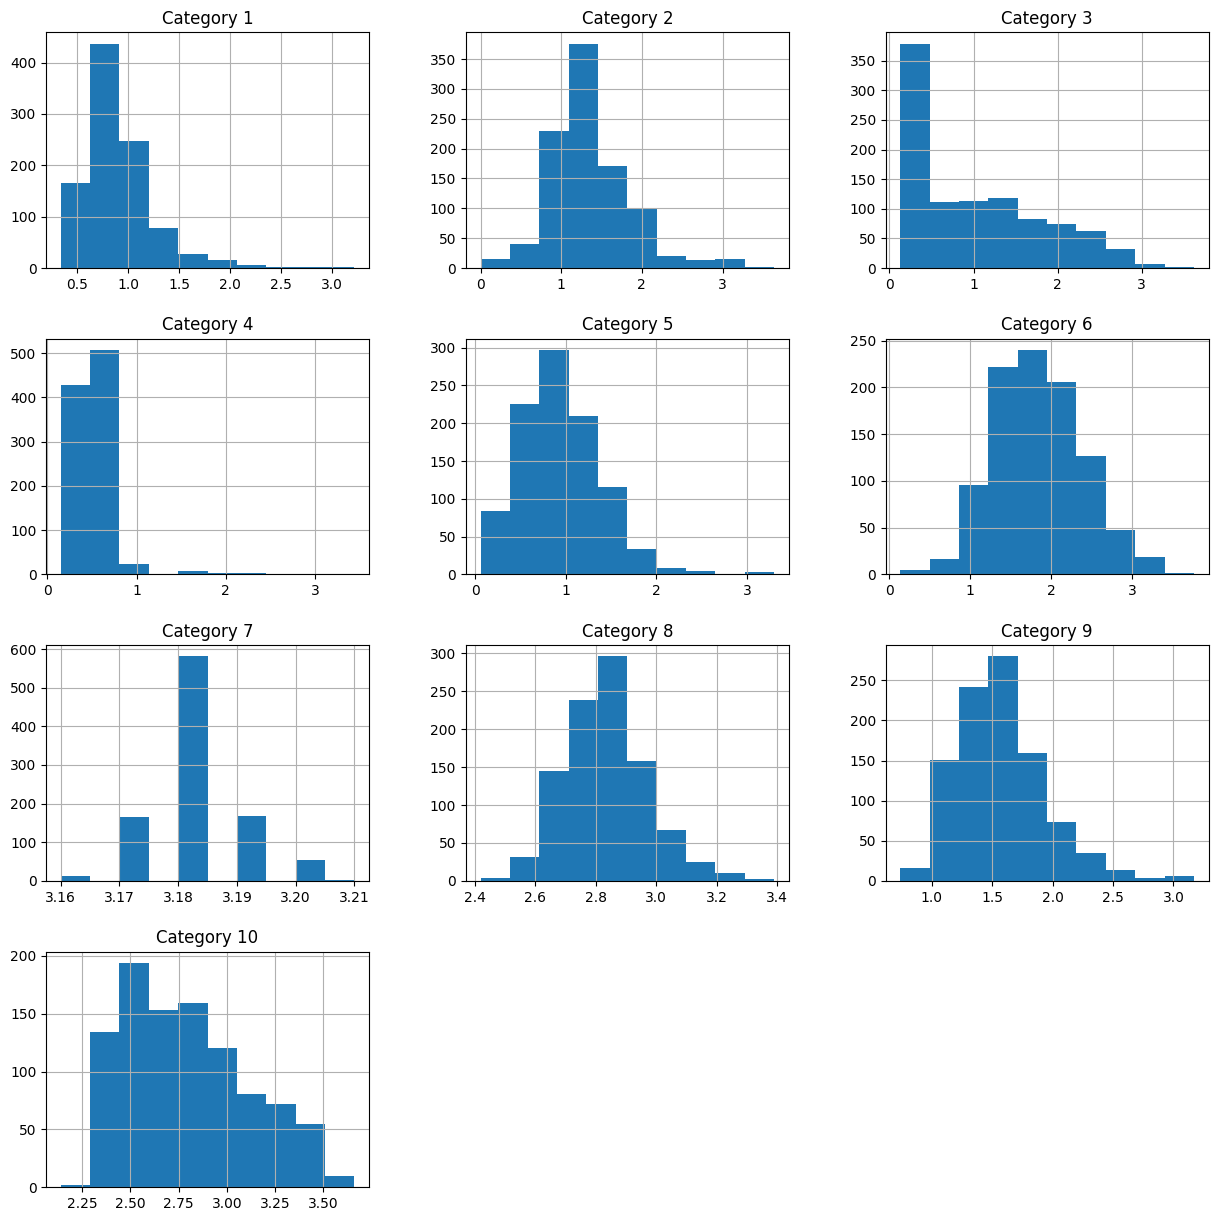

In [120]:
dataset.hist(figsize=(15,15))

## Using elbow method to find the optimal amount of clusters

The reason for choosing this method, is because it helps us determine the optimal number of clusters by plotting the variance against the number of clusters. So in essence we are trying to find a balance where adding more clusters will give us less improvements. The optimal number of clusters will capture the structure of the data without overfitting.

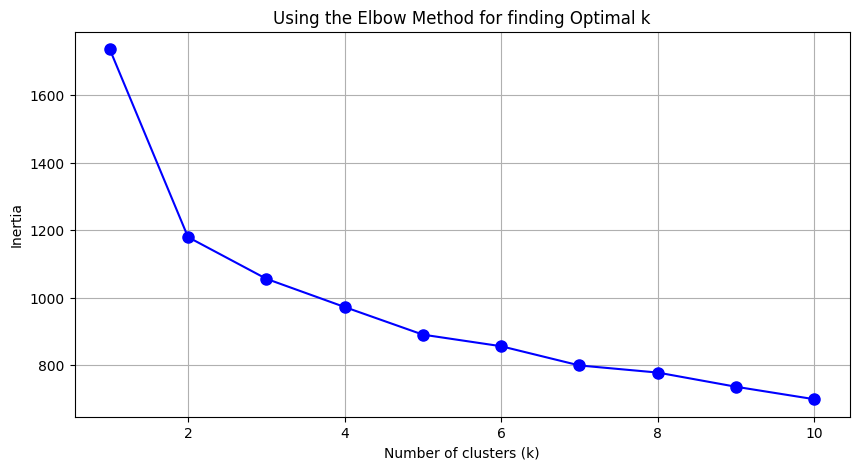

In [105]:
k_range = range(1,11)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Using the Elbow Method for finding Optimal k')
plt.grid()
plt.show()

## Observing the drop in the graph using the elbow method, and deciding the the k

We can observe that the inertia of the k slows down significantly after hitting 2 cluster.There’s no clear elbow, but a noticeable bend occurs around k=3. and the curve starts flattening around k=3 to k5. So I will try both k=3 and k=4 and compare the results between the two.


## Using silhouete method to find the amount of clusters


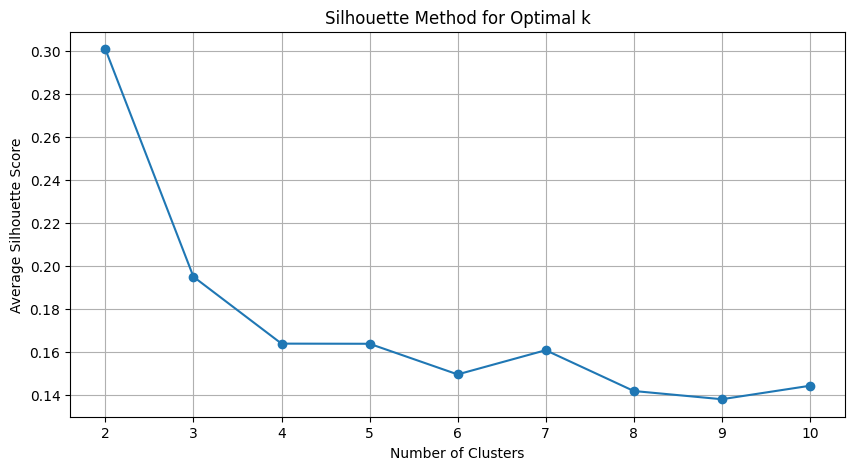

In [106]:
range_n_clusters = range(2, 11)
silhouette_avg = []

for k in range_n_clusters:
    clusterer = KMeans(n_clusters=k, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset)

    silhouette_avg.append(silhouette_score(dataset, cluster_labels))

plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()


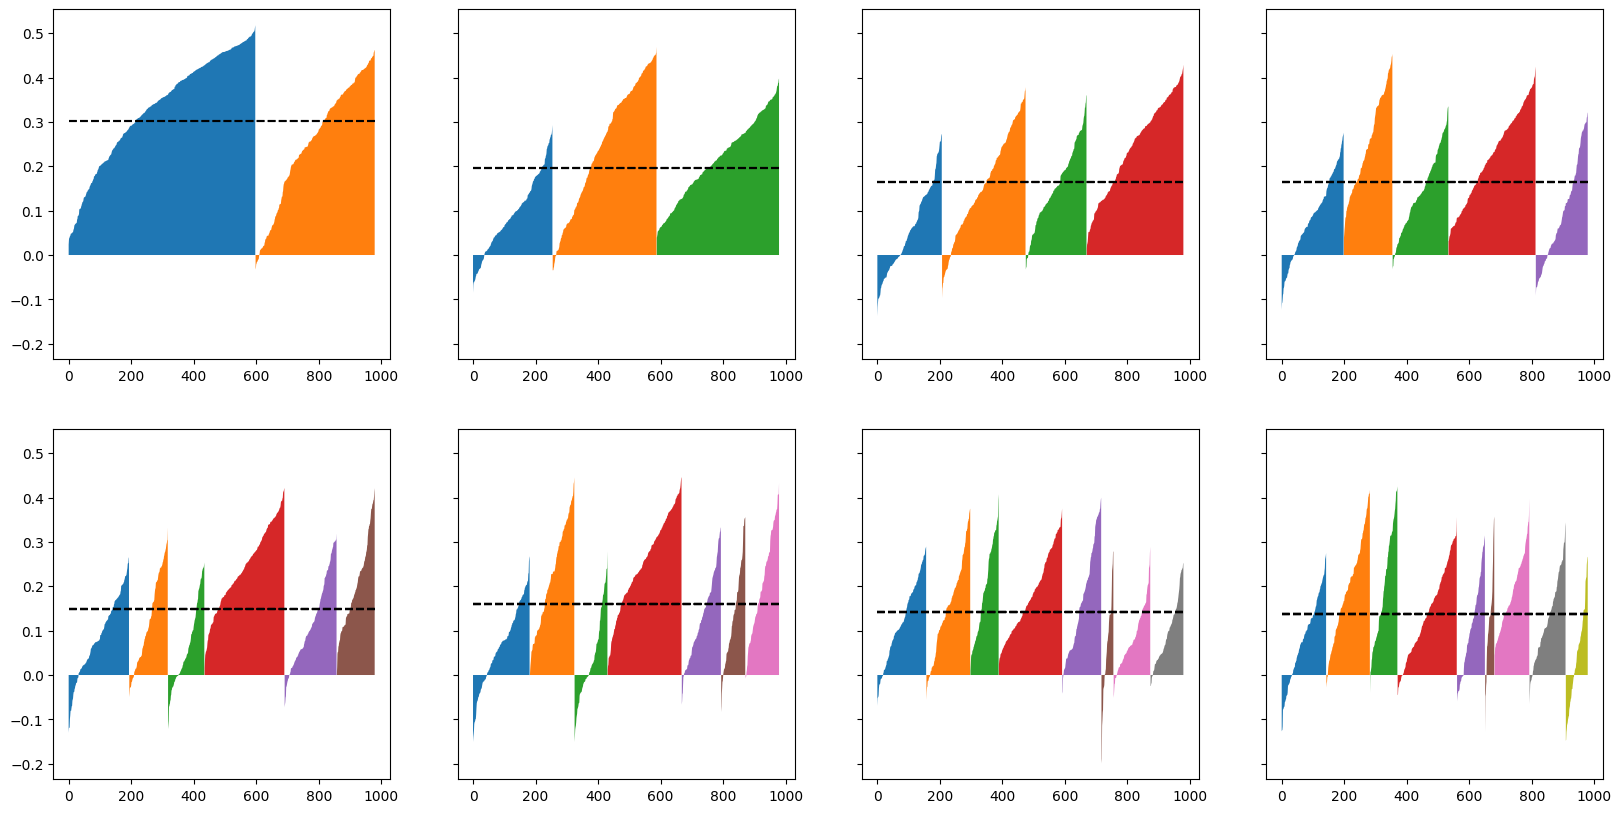

In [107]:
# Silhouette method for finding natural clusters
n_clusters = range(2,10)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
for i in n_clusters:
    km = KMeans(n_clusters=i, random_state=42).fit(dataset)
    silhouette_average = silhouette_score(dataset, km.labels_)
    sample_silhouette = silhouette_samples(dataset, km.labels_)
    x_start = 0
    for cluster_i in range(i):
        ith_cluster_samples = sample_silhouette[km.labels_ == cluster_i]
        ith_cluster_samples.sort()
        x_end = x_start + ith_cluster_samples.shape[0]
        ax[(i-2)//4][(i-2)%4].fill_between(np.arange(x_start, x_end), 0, ith_cluster_samples)
        ax[(i-2)//4][(i-2)%4].plot([0,sample_silhouette.shape[0]],[silhouette_average, silhouette_average], '--', color='black')
        x_start = x_end


## The observation
We make the observation that the sizes of the clusters varies a lot, when we want them to be more equal in size.

## Creating our KMeans cluster

In [108]:
kmeans_model1 = KMeans(n_clusters=3,random_state=42)
kmeans_model1.fit(dataset)

KMeans(n_clusters=3, random_state=42)

In [109]:
silhouette_score(dataset, kmeans_model1.labels_)
silhouette_score(dataset, kmeans_model1.predict(dataset))

np.float64(0.1951223938451225)

In [110]:
davies_bouldin_score(dataset, kmeans_model1.labels_)

np.float64(1.8181466695307649)

In [111]:
kmeans_model2 = KMeans(n_clusters=4,random_state=42)
kmeans_model2.fit(dataset)

KMeans(n_clusters=4, random_state=42)

In [112]:
silhouette_score(dataset, kmeans_model2.labels_)
silhouette_score(dataset, kmeans_model2.predict(dataset))

np.float64(0.16401823215666964)

In [113]:
davies_bouldin_score(dataset, kmeans_model2.labels_)
davies_bouldin_score(dataset, kmeans_model2.labels_)

np.float64(1.728451579641661)

## Comparing k=3 and k=4 

The observation is that k=3 performs better than k=4. However the neither of the results are not impressive to say the least.

In [114]:
#sb.scatterplot(data=dataset)

#### Optional junk

In [115]:
'''
from clusteval import clusteval
ce = clusteval(evaluate='silhouette')

# Fit
ce.fit(dataset)

# Plot
ce.plot()
ce.plot_silhouette()
ce.scatter()
ce.dendrogram()
'''

"\nfrom clusteval import clusteval\nce = clusteval(evaluate='silhouette')\n\n# Fit\nce.fit(dataset)\n\n# Plot\nce.plot()\nce.plot_silhouette()\nce.scatter()\nce.dendrogram()\n"